## Imports


In [5]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import threading
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression


sns.set()

## Create or Load Dataset
[OpenAlex](https://docs.openalex.org/) is used to create the dataset.
- [Here](https://docs.google.com/spreadsheets/d/1v-MAq64x4YjhO7RWcB-yrKV5D_2vOOsxl4u6GBKEXY8/edit#gid=983250122) is a list of all the topics and their associated ids.

In [128]:
endpoint = "https://api.openalex.org/works"

earliest_date = "1980-01-01"
latest_date = "2020-01-01"


def get_random_works(num_works=20, field_id=17):
    filter_string = f"filter=from_publication_date:{earliest_date},to_publication_date:{latest_date},has_oa_accepted_or_published_version:true,type:article,language:en,primary_topic.field.id:{field_id}"
    select_string = f"select=id,display_name,publication_year,authorships,countries_distinct_count,institutions_distinct_count,cited_by_count"
    page = 1
    items = []
    while len(items) < num_works:
        endpoint = f"https://api.openalex.org/works?sample={num_works}&per-page=200&page={page}&seed=123&{filter_string}&{select_string}"
        response = requests.get(endpoint)
        data = response.json()
        items.extend(data['results'])
        print(f"Fetched {len(items)} papers")
        page += 1
    return items


# for author, get list of past works before specific date
# create unique list of total Domains, fields, and subfields
def get_author_experience(author_id, date):
    select_string = "select=topics"
    endpoint = f"https://api.openalex.org/authors/{author_id}?{select_string}"

    res = requests.get(endpoint)
    data = res.json()
    author_topics = data["topics"]
    
    topics, domains, fields, subfields = [], [], [], []
    for t in author_topics:
        topics.append(t["display_name"])
        domains.append(t["domain"]["display_name"])
        subfields.append(t["subfield"]["display_name"])
        fields.append(t["field"]["display_name"])
    topics = list(set(topics))
    domains = list(set(domains))
    fields = list(set(fields))
    subfields = list(set(subfields))
    
    return topics, domains, fields, subfields

In [137]:
def process_papers(batches_ref, paper_data):
    papers = {
        "title": [],
        "countries_distinct_count": [],
        "institutions_distinct_count": [],
        "cited_by_count": [],
        "publication_year": [],
        "id": [],
        "num_authors": [],
        "total_author_domain_count": [],
        "mean_author_domain_count": [],
        "max_author_domain_count": [],
        "total_author_field_count": [],
        "mean_author_field_count": [],
        "max_author_field_count": [],
        "total_author_subfield_count": [],
        "mean_author_subfield_count": [],
        "max_author_subfield_count": [],
    }
    for i, p_data in enumerate(paper_data):
    
        # print(p_data["authorships"])
        author_ids = [author["author"]["id"].split("/")[-1] for author in p_data["authorships"]]
    
        total_topics = []
        total_domains = []
        total_fields = []
        total_subfields = []
    
        topic_counts = []
        domain_counts = []
        field_counts = []
        subfield_counts = []
        for author_id in author_ids:
            topics, domains, fields, subfields = get_author_experience(author_id, str(p_data["publication_year"])+"-01-01")
            total_topics.extend(topics)
            total_domains.extend(domains)
            total_fields.extend(fields)
            total_subfields.extend(subfields)
            topic_counts.append(len(topics))
            domain_counts.append(len(domains))
            field_counts.append(len(fields))
            subfield_counts.append(len(subfields))
    
        total_topics = list(set(total_topics))
        total_domains = list(set(total_domains))
        total_fields = list(set(total_fields))
        total_subfields = list(set(total_subfields))
        
        num_authors = len(author_ids)
        
        total_author_domain_count = len(total_domains)
        mean_author_domain_count = 0 if total_author_domain_count == 0 else np.mean(domain_counts)
        max_author_domain_count = 0 if total_author_domain_count == 0 else np.max(domain_counts)
        
        total_author_field_count = len(total_fields)
        mean_author_field_count = 0 if total_author_field_count == 0 else np.mean(field_counts)
        max_author_field_count = 0 if total_author_field_count == 0 else np.max(field_counts)
        
        total_author_subfield_count = len(total_subfields)
        mean_author_subfield_count = 0 if total_author_subfield_count == 0 else np.mean(subfield_counts)
        max_author_subfield_count = 0 if total_author_subfield_count == 0 else np.max(subfield_counts)
        
    
        papers["title"].append(p_data["display_name"])
        papers["countries_distinct_count"].append(p_data["countries_distinct_count"])
        papers["institutions_distinct_count"].append(p_data["institutions_distinct_count"])
        papers["cited_by_count"].append(p_data["cited_by_count"])
        papers["publication_year"].append(p_data["publication_year"])
        papers["id"].append(p_data["id"])
        papers["num_authors"].append(num_authors)
        papers["total_author_domain_count"].append(total_author_domain_count)
        papers["mean_author_domain_count"].append(mean_author_domain_count)
        papers["max_author_domain_count"].append(max_author_domain_count)
        papers["total_author_field_count"].append(total_author_field_count)
        papers["mean_author_field_count"].append(mean_author_field_count)
        papers["max_author_field_count"].append(max_author_field_count)
        papers["total_author_subfield_count"].append(total_author_subfield_count)
        papers["mean_author_subfield_count"].append(mean_author_subfield_count)
        papers["max_author_subfield_count"].append(max_author_subfield_count)

        if i % 10 == 0:
            print(f"[{threading.current_thread().name}] has processed {i}/{len(paper_data)} papers")
    
    df = pd.DataFrame(papers)
    batches_ref.append(df)

def create_dataset(num=20):
    paper_data = get_random_works(num)

    n_threads = 10
    threads = []
    batches = []
    batch_size = len(paper_data) // n_threads
    start = 0
    for i in range(n_threads):
        threads.append(threading.Thread(target=process_papers, args=(batches, paper_data[start:start+batch_size]), name=f"Thread {i}"))
        start += batch_size

    for thread in threads:
        thread.start()

    for thread in threads:
        thread.join()
        
    master_df = pd.concat(batches, axis=0)
    return master_df
    

In [135]:
df = create_dataset(1000)
df.to_csv("papers1k.csv")

Fetched 200 papers
Fetched 400 papers
Fetched 600 papers
Fetched 800 papers
Fetched 1000 papers
[Thread 3] processed paper with 1 authors
[Thread 5] processed paper with 1 authors
[Thread 8] processed paper with 1 authors
[Thread 9] processed paper with 2 authors
[Thread 0] processed paper with 2 authors
[Thread 7] processed paper with 3 authors
[Thread 4] processed paper with 3 authors
[Thread 6] processed paper with 4 authors
[Thread 0] processed paper with 2 authors
[Thread 1] processed paper with 4 authors
[Thread 4] processed paper with 1 authors
[Thread 2] processed paper with 5 authors
[Thread 3] processed paper with 4 authors
[Thread 0] processed paper with 1 authors
[Thread 9] processed paper with 3 authors
[Thread 6] processed paper with 2 authors
[Thread 2] processed paper with 2 authors
[Thread 7] processed paper with 4 authors
[Thread 5] processed paper with 5 authors
[Thread 7] processed paper with 1 authors
[Thread 1] processed paper with 3 authors
[Thread 8] processed p

## EDA

In [3]:
df = pd.read_csv("data/papers10k.csv", index_col=0)
df.describe()

,countries_distinct_count,institutions_distinct_count,cited_by_count,publication_year,num_authors,total_author_domain_count,mean_author_domain_count,max_author_domain_count,total_author_field_count,mean_author_field_count,max_author_field_count,total_author_subfield_count,mean_author_subfield_count,max_author_subfield_count
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,0.941556,1.234556,18.500556,2011.205000,2.754556,3.099222,2.427521,2.984222,8.473667,5.180096,6.744889,20.662667,10.327470,13.461111
std,0.749208,1.266555,97.550844,8.745254,2.145368,1.071009,0.856509,1.038955,4.336519,2.306706,2.921278,13.114199,4.825326,5.746104
min,0.000000,0.000000,0.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,2008.000000,1.000000,2.000000,2.000000,2.000000,5.000000,3.666667,5.000000,12.000000,7.250000,11.000000
50%,1.000000,1.000000,2.000000,2014.000000,2.000000,3.000000,2.500000,3.000000,8.000000,5.250000,7.000000,19.000000,10.857143,15.000000
75%,1.000000,2.000000,11.000000,2018.000000,4.000000,4.000000,3.000000,4.000000,11.000000,6.666667,9.000000,28.000000,13.800000,18.000000
max,14.000000,27.000000,5016.000000,2020.000000,69.000000,4.000000,4.000000,4.000000,26.000000,15.000000,15.000000,128.000000,23.000000,25.000000


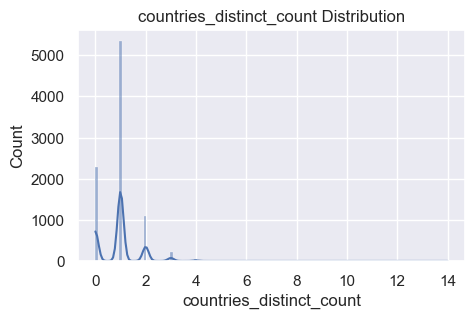

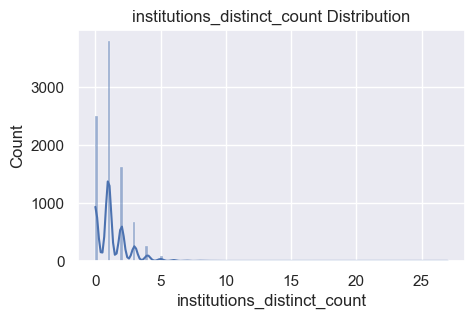

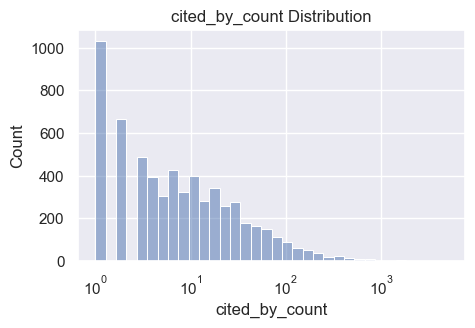

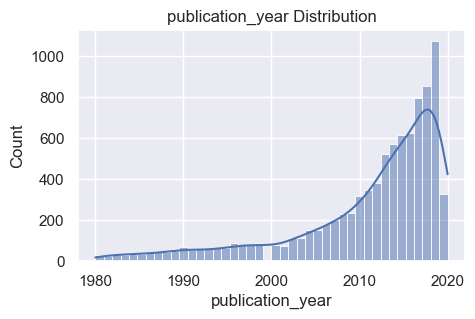

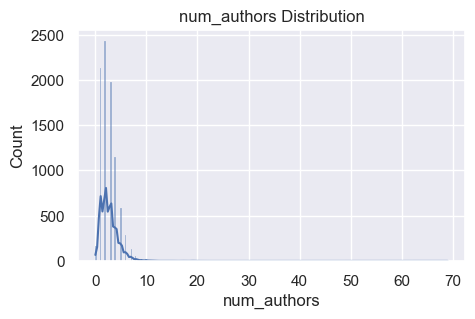

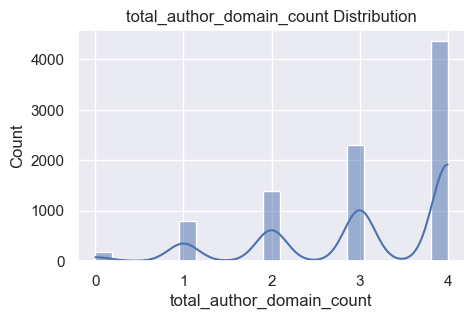

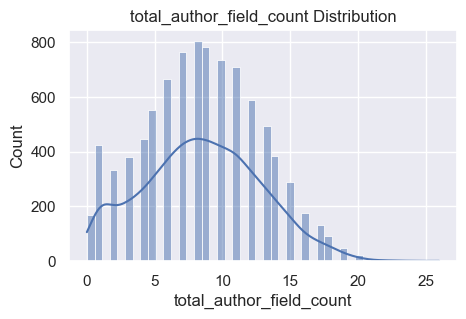

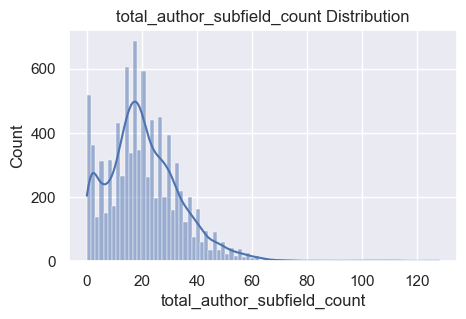

In [81]:
numerical_features = ['countries_distinct_count', 
                      'institutions_distinct_count', 
                      'cited_by_count', 
                      'publication_year', 
                      'num_authors', 
                      'total_author_domain_count',
                      'total_author_field_count',
                      'total_author_subfield_count'
                     ]
log_scale = ['cited_by_count']
for ftr in numerical_features:
    plt.figure(figsize=(5, 3))
    sns.histplot(df[ftr], kde=True, log_scale=(ftr in log_scale))
    plt.title(f"{ftr} Distribution")
    plt.savefig(f"charts/{ftr}_distribution.png",bbox_inches='tight')
    plt.show()

## Analysis


In [68]:
df.corr(numeric_only=True)

,countries_distinct_count,institutions_distinct_count,cited_by_count,publication_year,num_authors,total_author_domain_count,mean_author_domain_count,max_author_domain_count,total_author_field_count,mean_author_field_count,max_author_field_count,total_author_subfield_count,mean_author_subfield_count,max_author_subfield_count
countries_distinct_count,1.000000,0.786293,0.083686,0.069941,0.334332,0.249165,0.139000,0.225375,0.292986,0.148017,0.221969,0.320158,0.184771,0.250343
institutions_distinct_count,0.786293,1.000000,0.074863,0.101712,0.447202,0.267594,0.141606,0.244163,0.356349,0.155070,0.252630,0.413877,0.188021,0.269246
cited_by_count,0.083686,0.074863,1.000000,-0.081122,0.037107,0.043223,0.048530,0.043523,0.058749,0.060726,0.050462,0.054981,0.063292,0.048402
publication_year,0.069941,0.101712,-0.081122,1.000000,0.142728,0.079098,-0.002086,0.069628,0.078825,-0.059906,0.032791,0.081844,-0.094636,-0.000661
num_authors,0.334332,0.447202,0.037107,0.142728,1.000000,0.392327,0.124415,0.362452,0.563288,0.104443,0.367215,0.694314,0.133575,0.377235
total_author_domain_count,0.249165,0.267594,0.043223,0.079098,0.392327,1.000000,0.816053,0.953626,0.789752,0.672889,0.788726,0.692024,0.649639,0.768210
mean_author_domain_count,0.139000,0.141606,0.048530,-0.002086,0.124415,0.816053,1.000000,0.846864,0.632918,0.812404,0.700040,0.517506,0.750467,0.652053
max_author_domain_count,0.225375,0.244163,0.043523,0.069628,0.362452,0.953626,0.846864,1.000000,0.768372,0.688244,0.796436,0.668142,0.650599,0.758932
total_author_field_count,0.292986,0.356349,0.058749,0.078825,0.563288,0.789752,0.632918,0.768372,1.000000,0.753908,0.901690,0.918185,0.708277,0.833785
mean_author_field_count,0.148017,0.155070,0.060726,-0.059906,0.104443,0.672889,0.812404,0.688244,0.753908,1.000000,0.856590,0.604117,0.907676,0.774258


In [59]:
X = df.copy()

Y = X['cited_by_count']
X.drop(columns=['cited_by_count', 'title', 'id', 'total_author_subfield_count', 'mean_author_subfield_count', 'max_author_subfield_count'], inplace=True)
features_used = X.columns.to_list()
X = np.asarray(X)

# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X)
results = model.fit()

# Print the summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         cited_by_count   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     15.95
Date:                Mon, 06 May 2024   Prob (F-statistic):           7.77e-29
Time:                        23:07:20   Log-Likelihood:                -53914.
No. Observations:                9000   AIC:                         1.079e+05
Df Residuals:                    8989   BIC:                         1.079e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1943.3525    240.282      8.088      0.0

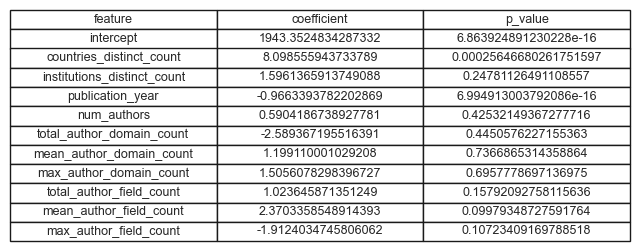

In [60]:
results_table = {
    "feature": ["intercept"] + features_used,
    "coefficient": results.params.to_list(),
    "p_value": results.pvalues.to_list()
}
results_df = pd.DataFrame(results_table)

fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as needed
ax.axis('off')  # Turn off the axis
ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

# Display the table
plt.show()

In [61]:
model = LinearRegression()

model.fit(X, Y)
R2 = model.score(X, Y)
print("R2: "+str(R2))

coef, intercept = model.coef_, model.intercept_

for ftr, coef in zip(features_used, coef):
    print(f"{ftr}: {coef}")

R2: 0.01743323263737484
countries_distinct_count: 0.0
institutions_distinct_count: 8.098555943733809
publication_year: 1.5961365913749006
num_authors: -0.9663393782202889
total_author_domain_count: 0.5904186738928251
mean_author_domain_count: -2.5893671955164064
max_author_domain_count: 1.1991100010293216
total_author_field_count: 1.5056078298396185
mean_author_field_count: 1.0236458713511865
max_author_field_count: 2.370335854891428


positive coefficients on the max_author_counts could be interpreted to mean that it's good to have one generalist on the team, yet the mean_author_domain count has a negative coefficient, perhaps suggesting that more than one generalist sacrifices too much depth. 

### Papers with >10 citations

In [62]:
at_least_10_citations = df[df['cited_by_count'] >= 10]
print(at_least_10_citations.describe())

X = df.copy()

Y = X['cited_by_count']
X.drop(columns=['cited_by_count', 'title', 'id', 'total_author_subfield_count', 'mean_author_subfield_count', 'max_author_subfield_count'], inplace=True)
features_used = X.columns
X = np.asarray(X)

model = LinearRegression()

model.fit(X, Y)
R2 = model.score(X, Y)
print("R2: "+str(R2))

coef, intercept = model.coef_, model.intercept_

for ftr, coef in zip(features_used, coef):
    print(f"{ftr}: {coef}")

       countries_distinct_count  institutions_distinct_count  cited_by_count  \
count               2496.000000                  2496.000000     2496.000000   
mean                   1.255208                     1.744391       61.727965   
std                    0.729134                     1.310497      178.102452   
min                    0.000000                     0.000000       10.000000   
25%                    1.000000                     1.000000       15.000000   
50%                    1.000000                     1.000000       25.000000   
75%                    2.000000                     2.000000       52.000000   
max                    5.000000                    16.000000     5016.000000   

       publication_year  num_authors  total_author_domain_count  \
count       2496.000000  2496.000000                2496.000000   
mean        2010.035256     3.357372                   3.392628   
std            8.942723     2.528810                   0.840656   
min        

                            OLS Regression Results                            
Dep. Variable:         cited_by_count   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     15.95
Date:                Mon, 06 May 2024   Prob (F-statistic):           7.77e-29
Time:                        23:07:57   Log-Likelihood:                -53914.
No. Observations:                9000   AIC:                         1.079e+05
Df Residuals:                    8989   BIC:                         1.079e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1943.3525    240.282      8.088      0.0

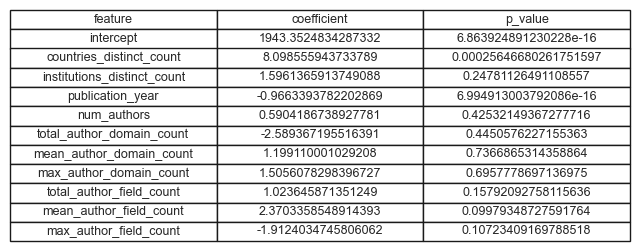

In [65]:
# Add a constant term to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(Y, X)
results = model.fit()

# Print the summary
print(results.summary())

results_table = {
    "feature": ["intercept"] + features_used.to_list(),
    "coefficient": results.params.to_list(),
    "p_value": results.pvalues.to_list()
}

results_df = pd.DataFrame(results_table)

fig, ax = plt.subplots(figsize=(8, 3))  # Adjust the figure size as needed
ax.axis('off')  # Turn off the axis
ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

# Display the table
plt.show()

**teams with more author affiliations (i.e. the number of unique universities or organizations that the authors are affiliated with) will experience greater variance in the number of citations compared to papers authored by teams of a comparable size but more homogeneity**



In [77]:
possible_num_authors = sorted(df["num_authors"].unique())

high_affil_var = df[df["institutions_distinct_count"] > 2]["cited_by_count"].var()
low_affil_var = df[df["institutions_distinct_count"] < 3]["cited_by_count"].var()
print(f"overall high var: {high_affil_var}. overall low var: {low_affil_var}")

for n_auth in possible_num_authors:
    high_affil_mask = (df["num_authors"] == n_auth) & (df["institutions_distinct_count"] > 1)
    low_affil_mask = (df["num_authors"] == n_auth) & (df["institutions_distinct_count"] == 1)
    high_affil = df[high_affil_mask]["cited_by_count"]
    low_affil = df[low_affil_mask]["cited_by_count"]

    print(f"With team size of {n_auth}:\n\thigh affiliations (mean / var): {high_affil.mean()} / {high_affil.var()}\n\tlow affiliations (mean / var): {low_affil.mean()} / {low_affil.var()}")

overall high var: 20670.523436330215. overall low var: 7923.8123406934865
With team size of 0:
	high affiliations (mean / var): nan / nan
	low affiliations (mean / var): nan / nan
With team size of 1:
	high affiliations (mean / var): 9.918032786885245 / 628.1419861807348
	low affiliations (mean / var): 24.002734731084775 / 37655.002729741056
With team size of 2:
	high affiliations (mean / var): 29.995073891625616 / 34429.97530464081
	low affiliations (mean / var): 17.598275862068967 / 2889.2362351611005
With team size of 3:
	high affiliations (mean / var): 22.11392405063291 / 2810.0841861294407
	low affiliations (mean / var): 17.78048780487805 / 3777.843618831526
With team size of 4:
	high affiliations (mean / var): 24.596153846153847 / 3454.3182338677075
	low affiliations (mean / var): 17.199481865284973 / 2114.513350380184
With team size of 5:
	high affiliations (mean / var): 38.46894409937888 / 10497.570683616803
	low affiliations (mean / var): 20.56024096385542 / 5378.817561153698


**papers with more countries represented among the authors will have higher variance in the number of citations.**


In [87]:
high_countries_var = df[df["countries_distinct_count"] > 1]["cited_by_count"].var()
low_countries_var = df[df["countries_distinct_count"] == 1]["cited_by_count"].var()
print(f"overall high countries variance: {high_countries_var}\noverall low countries variance: {low_countries_var}")
print(len(df[df["countries_distinct_count"] > 1]))

overall high countries variance: 17807.988769969663
overall low countries variance: 10479.004931781203
1379


**teams with at least one “generalist” individual will have higher variance**

In [83]:
high_max_field_var = df[df["max_author_field_count"] > 10]["cited_by_count"].var()
low_max_field_var = df[df["max_author_field_count"] <= 10]["cited_by_count"].var()
print(f"overall high max field count variance: {high_max_field_var}\noverall low max field count variance: {low_max_field_var}")

overall high max field count variance: 28531.665499746166
overall low max field count variance: 7838.848355310404


In [84]:
high_max_domain_var = df[df["max_author_domain_count"] > 1]["cited_by_count"].var()
low_max_domain_var = df[df["max_author_domain_count"] == 1]["cited_by_count"].var()
print(f"overall high max domain count variance: {high_max_domain_var}\noverall low max domain count variance: {low_max_domain_var}")

overall high max domain count variance: 10514.920586957625
overall low max domain count variance: 1081.10148694917
